<a href="https://colab.research.google.com/github/juliogdomingues/ibd_ufmg/blob/main/tp2_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Título

Processamento de petróleo e produção de derivados

# 2. Membros (nome e número de matrícula)

Nome                          Matrícula

Gustavo Chaves Ferreira       2022043329

Júlio Guerra Domingues        2022431280

Manuel Junio Ferraz Cardoso   2022102465

Marcos Daniel Souza Netto     2022069492



# 3. Descrição dos dados (qual a URL? qual o domínio? como os dados foram processados?)

URL: https://dados.gov.br/dados/conjuntos-dados/processamento-de-petroleo-e-producao-de-derivados

Assunto: Processamento de petróleo e produção de derivados

Entidade responsável: Agência Nacional do Petróleo, Gás Natural e Biocombustíveis (ANP)

O banco de dados, atualizado mensalmente, contém informações sobre o processamento de petróleo e produção de derivados no território brasileiro.


Streamlit: https://tp2-ibd.streamlit.app/

Descrição:

Entidades

1. Produto
* ProdID: Chave primária identificadora do produto, tipo INTEGER;
* Nome: Nome do produto, tipo TEXT, não nulo;
* Unidade: Unidade de medida do produto, tipo TEXT, não nulo.
2. Estado
* EstadoID: Chave primária identificadora do estado, tipo INTEGER;
* Estado: Nome do estado, tipo TEXT, não nulo;
* Regiao: Macrorregião geoeconômica do estado, tipo TEXT, não nulo.
3. Refinaria
* EmpID: Chave primária identificadora da refinaria, tipo INTEGER;
* CNPJ: CNPJ da refinaria, tipo TEXT, não nulo;
* Instalacao: Nome da instalação da refinaria, tipo TEXT, não nulo;
* RazaoSocial: Razão social da empresa que opera a refinaria, tipo TEXT, não nulo;
* Municipio: Município onde a refinaria está localizada, tipo TEXT, não nulo.
4. Empresa
* EmpID: Chave primária identificadora da empresa, tipo INTEGER;
* Nome: Nome da empresa, tipo TEXT, não nulo;
* EstadoID: Chave estrangeira que referencia 'Estado', não não nula;
* ProdutorIndependente: Indicador se a empresa é um produtor independente ou não (0 para não, 1 para sim) , tipo INTEGER, não nulo.
5. CentralPetroquimica
* EmpID: Chave primária identificadora da central petroquímica, tipo INTEGER;
* CNPJ: CNPJ da central petroquímica, tipo TEXT, não nula;
* Municipio: Município onde a central petroquímica está localizada, tipo TEXT, não nulo;
6. Autorizacao
* AutoID: Chave primária identificadora da autorização, tipo INTEGER;
* DataConcessao: Data da concessão da autorização, tipo DATE, não nulo;
* CNPJ: CNPJ da entidade que recebeu a autorização, tipo INTEGER, não nulo;
* Capacidade: Capacidade autorizada em m³/d, tipo INTEGER, não nulo.
7. Processamento
* CNPJ: Atributo de uma refinaria, componente da chave primária identificadora do processamento, tipo INTEGER, não nulo;
* AutoID: Identificador da autorização, componente da chave primária identificadora do processamento,  tipo INTEGER, não nulo;  
* Data: Registro do mês em que o processamento foi feito, componente da chave primária identificadora do processamento, tipo DATE, não nulo;
* Volume: Volume processado em m³/d, tipo INTEGER.
Producao
* EmpID: Identificador da empresa, componente da chave primária identificadora da produção, tipo INTEGER, não nulo;
* ProdID: Identificador do produto, componente da chave primária identificadora da produção, tipo INTEGER, não nulo;
* Data: Mês e ano em que a empresa produziu determinado produto, tipo DATE, não nulo;
* Quantidade: Número absoluto referente à quantidade produzida por determinada empresa em determinado mês/ano nas unidades próprias de cada produto, tipo REAL.

Relacionamentos

Localização (1:n)

Produz (m:n)

Processamento (1:n)



In [38]:
import sqlite3
import io
import pandas as pd

!git clone https://github.com/souza-marcos/Data_IBD.git

fatal: destination path 'Data_IBD' already exists and is not an empty directory.


### Importando direto o dump SQL

In [39]:
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

# Carregamento do dump
f = io.open('./Data_IBD/dump.sql', 'r', encoding='utf-8')
dump = f.read()
cursor.executescript(dump)

conn.close()

### Processando os dados

Processando os dados de múltiplos arquivos para o banco



In [40]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('databaseAUX.db')
c = conn.cursor()

path = './Data_IBD/'

df = pd.read_csv(path + 'Producao_Derivados_de_petroleo_por_refinaria.csv')
df.to_sql('ProdutosDerivadosRefinaria', conn, if_exists='replace', index=False)

df = pd.read_csv(path + 'Processamento_Petroleo.csv')
df.to_sql('ProcessamentoPetroleo', conn, if_exists='replace', index=False)

df = pd.read_csv(path + 'Producao_Derivados_Central_Petroquimica.csv')
df.to_sql('ProducaoDerivadosCentralPetroquimica', conn, if_exists='replace', index= False)

df = pd.read_csv(path + 'Producao_Derivados_Outros_Produtores.csv', sep=';')
df.to_sql('ProducaoDerivadosOutrosProdutores', conn, if_exists='replace', index= False)

df = pd.read_csv(path + 'Producao_Derivados_Xisto.csv', sep=';')
df.to_sql('ProducaoDerivadosXisto', conn, if_exists='replace', index= False)

df = pd.read_csv(path + 'Producao_Gas_Combustivel_por_Refinaria.csv', sep=';')
df.to_sql('ProducaoGasCombustivelporRefinaria', conn, if_exists='replace', index= False)

conn.commit()
conn.close()

In [41]:
import pandas as pd
import sqlite3
connAux = sqlite3.connect('databaseAUX.db')
c = connAux.cursor()

conn = sqlite3.connect('database.db')
c1 = conn.cursor()

df : pd.DataFrame

def insertProdutos():
    conn.execute('DROP TABLE IF EXISTS Produto;')

    query = '''

    SELECT DISTINCT Produto
        FROM ProdutosDerivadosRefinaria

    '''

    df_base = pd.read_sql(query, connAux)

    # Add a index column
    df_base['ProdID'] = df_base.index

    # Transform string between parentheses in the column 'Produto' in a new column called 'Unidade'
    df_base['Unidade'] = df_base['Produto'].str.extract(r'\((.*?)\)', expand=False)

    # Remove the parentheses and the content between them
    df_base['Produto'] = df_base['Produto'].str.slice_replace(start=-4, stop=-1, repl='').str.replace(')', '')

    # Rename the column 'Produto' to 'Nome'
    df_base.rename(columns={'Produto': 'Nome'}, inplace=True)


    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE Produto (
        ProdID INTEGER PRIMARY KEY,
        Nome TEXT NOT NULL,
        Unidade TEXT NOT NULL
    );

    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO Produto (ProdID, Nome, Unidade) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', '{}')".format(row.ProdID, row.Nome, row.Unidade)
        # print(insert_query)
        conn.execute(insert_query)

def insertStates():

    conn.execute('DROP TABLE IF EXISTS Estado;')

    # EstadoID, Estado, Regiao

    query = '''

    SELECT DISTINCT `Estado`, `Região`
        FROM ProdutosDerivadosRefinaria

    '''

    df_base = pd.read_sql(query, connAux)

    # Add a index column
    df_base['EstadoID'] = df_base.index

    # Rename the column 'Produto' to 'Nome'
    df_base.rename(columns={'Região': 'Regiao'}, inplace=True)


    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE Estado (
        EstadoID INTEGER PRIMARY KEY,
        Estado TEXT NOT NULL,
        Regiao TEXT NOT NULL
    );

    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO Estado (EstadoID, Estado, Regiao) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', '{}')".format(row.EstadoID, row.Estado, row.Regiao)
        # print(insert_query)
        conn.execute(insert_query)


    df = pd.read_sql('SELECT * FROM Estado', conn)
    # print(df)

def insertRefinarias():

    # EstadoID, Estado, Regiao

    states = pd.read_sql('SELECT * FROM Estado', conn)

    conn.execute('DROP TABLE IF EXISTS Refinaria;')
    conn.execute('DROP TABLE IF EXISTS Empresa;')

    query = '''

    SELECT `CNPJ`, `Instalação`, `Razão Social`, `Município`, `Estado`, `Região`
        FROM ProdutosDerivadosRefinaria
        GROUP BY `CNPJ`
    '''

    df_base = pd.read_sql(query, connAux)

    # Add a index column
    df_base['EmpID'] = df_base.index

    # Rename the column 'Produto' to 'Nome'
    df_base.rename(columns={'Razão Social': 'RazaoSocial'}, inplace=True)
    df_base.rename(columns={'Instalação': 'Instalacao'}, inplace=True)
    df_base.rename(columns={'Município': 'Municipio'}, inplace=True)
    df_base.rename(columns={'Região': 'Regiao'}, inplace=True)


    foreignKeyconstraint = 'PRAGMA foreign_keys = 0;'
    conn.execute(foreignKeyconstraint)

    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE Refinaria (
        EmpID INTEGER PRIMARY KEY,
        CNPJ TEXT NOT NULL,
        Instalacao TEXT NOT NULL,
        RazaoSocial TEXT NOT NULL,
        Municipio TEXT NOT NULL,
        FOREIGN KEY (EmpID) REFERENCES Empresa (EmpID)
    );

    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO Refinaria (EmpID, CNPJ, Instalacao, RazaoSocial, Municipio) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', '{}', '{}', '{}')".format(row.EmpID, row.CNPJ, row.Instalacao, row.RazaoSocial, row.Municipio)
        # print(insert_query)
        conn.execute(insert_query)


    # Inserindo esses registros na tabela Empresa
    create_table_query = '''

    CREATE TABLE Empresa (
        EmpID INTEGER PRIMARY KEY,
        Nome TEXT NOT NULL,
        EstadoID INTEGER,
        ProdutorIndependente INTEGER NOT NULL,
        FOREIGN KEY (EstadoID) REFERENCES Estado (EstadoID)
    );

    '''

    conn.execute(create_table_query)


    base_insert_query = '''
    INSERT INTO Empresa (EmpID, Nome, EstadoID, ProdutorIndependente) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', {}, {})".format(row.EmpID, row.Instalacao, states[states['Estado'] == row.Estado]['EstadoID'].values[0], 0)
        # print(insert_query)
        conn.execute(insert_query)


    df = pd.read_sql('SELECT * FROM Refinaria', conn)
    # print(df)

def insertPetroquimicas():

    states = pd.read_sql('SELECT * FROM Estado', conn)

    # EstadoID, Estado, Regiao

    c1.execute('SELECT MAX(EmpID) FROM Empresa')
    lastid = c1.fetchone()[0]

    conn.execute('DROP TABLE IF EXISTS CentralPetroquimica;')

    query = '''

    SELECT `CNPJ`, `Município`, `Estado`, `Região`, `Razão Social`
        FROM ProducaoDerivadosCentralPetroquimica
        GROUP BY `CNPJ`
    '''

    df_base = pd.read_sql(query, connAux)

    # Add a index column
    df_base['EmpID'] = df_base.index

    # Map the EmpID adding the last id of the table Refinaria
    df_base['EmpID'] = df_base['EmpID'].map(lambda x: x + (lastid + 1))


    df_base.rename(columns={'Município': 'Municipio'}, inplace=True)
    df_base.rename(columns={'Região': 'Regiao'}, inplace=True)
    df_base.rename(columns={'Razão Social': 'RazaoSocial'}, inplace=True)


    foreignKeyconstraint = 'PRAGMA foreign_keys = 0;'
    conn.execute(foreignKeyconstraint)

    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE CentralPetroquimica (
        EmpID INTEGER PRIMARY KEY,
        CNPJ TEXT NOT NULL,
        Municipio TEXT NOT NULL,
        FOREIGN KEY (EmpID) REFERENCES Empresa (EmpID)
    );

    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO CentralPetroquimica (EmpID, CNPJ, Municipio) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', '{}')".format(row.EmpID, row.CNPJ, row.Municipio)
        conn.execute(insert_query)


    # Inserindo esses registros na tabela Empresa
    base_insert_query = '''
    INSERT INTO Empresa (EmpID, Nome, EstadoID, ProdutorIndependente) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', {}, {})".format(row.EmpID, row.RazaoSocial, states[states['Estado'] == row.Estado]['EstadoID'].values[0], 0)
        # print(insert_query)
        conn.execute(insert_query)





    # df = pd.read_sql('SELECT * FROM CentralPetroquimica', conn)
    # print(df)

def insertAutorizacao():

    conn.execute('DROP TABLE IF EXISTS Autorizacao;')

    query = '''

    SELECT `Mês/Ano`, `CNPJ`, `Capacidade Autorizada (m³/d)`
        FROM ProcessamentoPetroleo
    '''

    df_base = pd.read_sql(query, connAux)

    # Renaming Columns
    df_base.rename(columns={'Mês/Ano': 'DataConcessao'}, inplace=True)
    df_base.rename(columns={'Capacidade Autorizada (m³/d)': 'Capacidade'}, inplace=True)

    df_base['DataConcessao'] = pd.to_datetime(df_base['DataConcessao'], format='%m/%Y')

    # Group by 'CNPJ' and 'Capacidade Autorizada (m³/d)', and then aggregate using the first 'Mês/Ano'
    df_base = df_base.groupby(['CNPJ', 'Capacidade']).agg({'DataConcessao': 'first'}).reset_index()

    # Add a index column
    df_base['AutoID'] = df_base.index

    foreignKeyconstraint = 'PRAGMA foreign_keys = 0;'
    conn.execute(foreignKeyconstraint)

    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE Autorizacao (
        AutoID INTEGER PRIMARY KEY,
        DataConcessao DATE NOT NULL,
        CNPJ TEXT NOT NULL,
        Capacidade INTEGER NOT NULL,
        FOREIGN KEY (CNPJ) REFERENCES Refinaria (CNPJ)
    );


    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO Autorizacao (AutoID, DataConcessao, CNPJ, Capacidade) VALUES
    '''


    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, '{}', '{}', {})".format(row.AutoID, row.DataConcessao, row.CNPJ, row.Capacidade)
        conn.execute(insert_query)


    df = pd.read_sql('SELECT * FROM Autorizacao', conn)
    # print(df)

def insertRegitroProcessamento():

    autorizacoes = pd.read_sql('SELECT * FROM Autorizacao', conn)

    conn.execute('DROP TABLE IF EXISTS Processamento;')

    query = '''

    SELECT *
        FROM ProcessamentoPetroleo
    '''

    df_base = pd.read_sql(query, connAux)

    df_base.rename(columns={'Município': 'Municipio'}, inplace=True)
    df_base.rename(columns={'Região': 'Regiao'}, inplace=True)
    df_base.rename(columns={'Razão Social': 'RazaoSocial'}, inplace=True)
    df_base.rename(columns={'Capacidade Autorizada (m³/d)': 'Capacidade'}, inplace=True)
    df_base.rename(columns={'Mês/Ano': 'Data'}, inplace=True)
    df_base.rename(columns={'Volume Processado  (m³/d)': 'Volume'}, inplace=True)


    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%m/%Y')
    df_base['Data'] = df_base['Data'].dt.strftime('%Y-%m-%d')

    autorizacoes['DataConcessao'] = pd.to_datetime(autorizacoes['DataConcessao'], format='%Y-%m-%d %H:%M:%S')
    autorizacoes['DataConcessao'] = autorizacoes['DataConcessao'].dt.strftime('%Y-%m-%d')

    # Ordering the authorization by Date
    autorizacoes.sort_values(by=['DataConcessao'], inplace=True)

    # print(autorizacoes)
    # print(refinarias)

    def getAutorizacao(row):
        res = autorizacoes[(autorizacoes['CNPJ'] == str(row.CNPJ)) & (autorizacoes['DataConcessao'] <= str(row.Data))].max()['AutoID']
        return res

    df_base['AutoID'] = df_base.apply(getAutorizacao, axis=1)

    foreignKeyconstraint = 'PRAGMA foreign_keys = 0;'
    conn.execute(foreignKeyconstraint)

    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE Processamento (
        CNPJ INTEGER NOT NULL,
        AutoID INTEGER NOT NULL,
        Data DATE NOT NULL,
        Volume INTEGER NOT NULL,
        PRIMARY KEY (CNPJ, AutoID, Data),
        FOREIGN KEY (CNPJ) REFERENCES Refinaria (CNPJ),
        FOREIGN KEY (AutoID) REFERENCES Autorizacao (AutoID)
    );

    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO Processamento (CNPJ, AutoID, Data, Volume) VALUES
    '''

    # print(df_base.columns)

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, {}, '{}', {})".format(row.CNPJ, row.AutoID, row.Data, row.Volume)
        conn.execute(insert_query)


    df = pd.read_sql('SELECT * FROM Processamento', conn)
    # print(df)

def insertRegistroProducaoRefinaria():

    conn.execute('DROP TABLE IF EXISTS Producao;')

    query = '''

    SELECT `CNPJ`, `Mês/Ano`, `Produto`, `Produção`
        FROM ProdutosDerivadosRefinaria
    '''

    df_base = pd.read_sql(query, connAux)

    df_base.rename(columns={'Mês/Ano': 'Data'}, inplace=True)
    df_base.rename(columns={'Produção': 'Quantidade'}, inplace=True)

    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%m/%Y')
    df_base['Data'] = df_base['Data'].dt.strftime('%Y-%m-%d')

    df_base['Produto'] = df_base['Produto'].str.slice_replace(start=-4, stop=-1, repl='').str.replace(')', '')


    # Linking the ProdID to the df_base
    produtos = pd.read_sql('SELECT * FROM Produto', conn)

    def getProdutoID(row):
        res = produtos[produtos['Nome'] == str(row.Produto)]['ProdID'].values[0]
        return res

    df_base['ProdID'] = df_base.apply(getProdutoID, axis=1)

    # Linking the EmpID to the df_base
    refinarias = pd.read_sql('SELECT EmpID, CNPJ FROM Refinaria', conn)

    def getEmpresaID(row):
        res = refinarias[refinarias['CNPJ'] == str(row.CNPJ)]['EmpID'].values[0]
        return res

    df_base['EmpID'] = df_base.apply(getEmpresaID, axis=1)



    foreignKeyconstraint = 'PRAGMA foreign_keys = 0;'
    conn.execute(foreignKeyconstraint)

    # Create a new table in the database databaseRight.db
    create_table_query = '''

    CREATE TABLE Producao (
        EmpID INTEGER NOT NULL,
        ProdID INTEGER NOT NULL,
        Data DATE NOT NULL,
        Quantidade REAL NOT NULL,
        PRIMARY KEY (EmpID, ProdID, Data),
        FOREIGN KEY (EmpID) REFERENCES Empresa (EmpID),
        FOREIGN KEY (ProdID) REFERENCES Produto (ProdID)
    );

    '''
    conn.execute(create_table_query)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT INTO Producao (EmpID, ProdID, Data, Quantidade) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, {}, '{}', {})".format(row.EmpID, row.ProdID, row.Data, row.Quantidade)
        conn.execute(insert_query)

    df = pd.read_sql('SELECT * FROM Producao', conn)
    # print(df)

def insertRegistroProducaoPetroquimica():

    query = '''

    SELECT `CNPJ`, `Mês/Ano`, `Produto`, `Produção`
        FROM ProducaoDerivadosCentralPetroquimica
    '''

    df_base = pd.read_sql(query, connAux)

    df_base.rename(columns={'Mês/Ano': 'Data'}, inplace=True)
    df_base.rename(columns={'Produção': 'Quantidade'}, inplace=True)

    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%m/%Y')
    df_base['Data'] = df_base['Data'].dt.strftime('%Y-%m-%d')

    maping = {
        'GASOLINA A COMUM': 'Gasolina A',
        'GASOLINA A PREMIUM': 'Gasolina A Premium',
        'GLP': 'GLP'
    }

    df_base['Produto'] = df_base['Produto'].map(maping)


    # Linking the ProdID to the df_base
    produtos = pd.read_sql('SELECT ProdID, Nome FROM Produto', conn)


    mapping_ProdsID = {
        'Gasolina A': produtos[produtos['Nome'] == 'Gasolina A ']['ProdID'].values[0],
        'Gasolina A Premium': produtos[produtos['Nome'] == 'Gasolina A Premium ']['ProdID'].values[0],
        'GLP': produtos[produtos['Nome'] == 'GLP ']['ProdID'].values[0]
    }


    df_base['ProdID'] = df_base['Produto'].map(mapping_ProdsID)

    # Linking the EmpID to the df_base
    petroquimicas = pd.read_sql('SELECT EmpID, CNPJ FROM CentralPetroquimica', conn)

    def getEmpresaID(row):
        res = petroquimicas[petroquimicas['CNPJ'] == str(row.CNPJ)]['EmpID'].values[0]
        return res

    df_base['EmpID'] = df_base.apply(getEmpresaID, axis=1)

    foreignKeyconstraint = 'PRAGMA foreign_keys = 0;'
    conn.execute(foreignKeyconstraint)

    # Insert into a table Produto in the database databaseRight.db with a sql query
    base_insert_query = '''
    INSERT OR IGNORE INTO Producao (EmpID, ProdID, Data, Quantidade) VALUES
    '''

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, {}, '{}', {})".format(row.EmpID, row.ProdID, row.Data, row.Quantidade)
        # print(insert_query)
        conn.execute(insert_query)

    df = pd.read_sql('SELECT * FROM Producao', conn)
    # print(df)

def insertFileDerivadosOutrosProdutores():

    # Inserindo na mao o produto 'OLEO DIESEL'
    lastid = pd.read_sql('SELECT MAX(ProdID) FROM Produto', conn).values[0][0]
    conn.execute('INSERT INTO Produto (ProdID, Nome, Unidade) VALUES ({}, "Oleo Diesel", "m³");'.format(lastid + 1))

    query = '''

    SELECT `ANO`, `MÊS`, `PRODUTOR`,`PRODUTO`, `PRODUÇÃO`
        FROM ProducaoDerivadosOutrosProdutores
        WHERE `PRODUÇÃO` != 0
    '''

    df_base = pd.read_sql(query, connAux)


    month_mapping = {
        'JAN': '01',
        'FEV': '02',
        'MAR': '03',
        'ABR': '04',
        'MAI': '05',
        'JUN': '06',
        'JUL': '07',
        'AGO': '08',
        'SET': '09',
        'OUT': '10',
        'NOV': '11',
        'DEZ': '12'
    }

    df_base['MÊS'] = df_base['MÊS'].map(month_mapping)
    df_base['Data'] = df_base['ANO'].astype(str) + '-' + df_base['MÊS'].astype(str) + '-01'
    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%Y-%m-%d')

    produtos = pd.read_sql('SELECT ProdID, Nome FROM Produto', conn)

    prods_mapping = {
        'GASOLINA A': produtos[produtos['Nome'] == 'Gasolina A ']['ProdID'].values[0],
        'SOLVENTE': produtos[produtos['Nome'] == 'Solventes ']['ProdID'].values[0],
        'OLEO DIESEL': produtos[produtos['Nome'] == 'Oleo Diesel']['ProdID'].values[0],
    }

    df_base['ProdID'] = df_base['PRODUTO'].map(prods_mapping)


    produtores = df_base['PRODUTOR'].drop_duplicates().reset_index(drop=True).to_frame()

    c1.execute('SELECT MAX(EmpID) FROM Empresa')
    lastid = c1.fetchone()[0]

    # Add a index column
    produtores['EmpID'] = produtores.index
    produtores['EmpID'] = produtores['EmpID'].map(lambda x: x + (lastid + 1))

    # Inserindo esses registros na tabela Empresa
    base_insert_query = '''
    INSERT INTO Empresa (EmpID, Nome, ProdutorIndependente) VALUES
    '''

    for row in produtores.itertuples():
        insert_query = base_insert_query + "({}, '{}', {})".format(row.EmpID, row.PRODUTOR, 1)
        conn.execute(insert_query)

    df_base['EmpID'] = df_base['PRODUTOR'].map(produtores.set_index('PRODUTOR')['EmpID'])

    base_insert_query = '''

    INSERT INTO Producao (EmpID, ProdID, Data, Quantidade) VALUES
    '''

    # Renaming column 'PRODUÇÃO' to 'Quantidade'
    df_base.rename(columns={'PRODUÇÃO': 'Quantidade'}, inplace=True)

    for row in df_base.itertuples():
        insert_query = base_insert_query + "({}, {}, '{}', '{}')".format(row.EmpID, row.ProdID, row.Data, row.Quantidade)
        conn.execute(insert_query)

    df = pd.read_sql('SELECT * FROM Producao', conn)
    # print(df)

def insertingXisto():

    # Inserindo na mao o produto 'OLEO DIESEL'
    lastid = pd.read_sql('SELECT MAX(ProdID) FROM Produto', conn).values[0][0]
    conn.execute('INSERT INTO Produto (ProdID, Nome, Unidade) VALUES ({}, "Outros não Energéticos", "");'.format(lastid + 1))

    query = '''

    SELECT `ANO`, `MÊS`, `UNIDADE DA FEDERAÇÃO` as UF, PRODUTOR, PRODUTO, PRODUÇÃO as Quantidade
        FROM ProducaoDerivadosXisto
        WHERE `PRODUÇÃO` != 0
    '''

    df_base = pd.read_sql(query, connAux)


    month_mapping = {
        'JAN': '01',
        'FEV': '02',
        'MAR': '03',
        'ABR': '04',
        'MAI': '05',
        'JUN': '06',
        'JUL': '07',
        'AGO': '08',
        'SET': '09',
        'OUT': '10',
        'NOV': '11',
        'DEZ': '12'
    }

    df_base['MÊS'] = df_base['MÊS'].map(month_mapping)
    df_base['Data'] = df_base['ANO'].astype(str) + '-' + df_base['MÊS'].astype(str) + '-01'
    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%Y-%m-%d')

    produtos = pd.read_sql('SELECT ProdID, Nome FROM Produto', conn)

    prods_mapping = {
        'OUTROS NÃO ENERGÉTICOS': produtos[produtos['Nome'] == 'Outros não Energéticos']['ProdID'].values[0],
        'NAFTA': produtos[produtos['Nome'] == 'Nafta ']['ProdID'].values[0],
        'GLP' : produtos[produtos['Nome'] == 'GLP ']['ProdID'].values[0],
        'DIESEL': produtos[produtos['Nome'] == 'Oleo Diesel']['ProdID'].values[0],
        'ÓLEO COMBUSTÍVEL': produtos[produtos['Nome'] == 'Óleo Combustível ']['ProdID'].values[0],
    }

    df_base['ProdID'] = df_base['PRODUTO'].map(prods_mapping)


    c1.execute('SELECT MAX(EmpID) FROM Empresa')
    lastid = c1.fetchone()[0]

    # Getting the id of the state of Paraná
    last_id_state = pd.read_sql('SELECT MAX(EstadoID) FROM Estado', conn).values[0][0]
    conn.execute('INSERT INTO Estado (EstadoID, Estado, Regiao) VALUES ({}, "Paraná", "SUL");'.format(last_id_state + 1))

   # Inserindo esses registros na tabela Empresa

    conn.execute('INSERT INTO Empresa (EmpID, EstadoID, Nome, ProdutorIndependente) VALUES ({}, {}, "SIX", 1);'.format(lastid + 1,last_id_state + 1))

    empID = lastid + 1

    base_insert_query = '''

    INSERT INTO Producao (EmpID, ProdID, Data, Quantidade) VALUES
    '''


    for row in df_base.itertuples():
        # print(empID, row.ProdID, row.Data, row.Quantidade)
        insert_query = base_insert_query + "({}, {}, '{}', '{}')".format(empID, row.ProdID, row.Data, row.Quantidade)
        conn.execute(insert_query)

    # df = pd.read_sql('SELECT * FROM Producao', conn)
    # print(df)

insertProdutos()
insertStates()
insertRefinarias()
insertPetroquimicas()
insertAutorizacao()
insertRegitroProcessamento()
insertRegistroProducaoRefinaria()
insertRegistroProducaoPetroquimica()
insertFileDerivadosOutrosProdutores()
insertingXisto()

connAux.close()

conn.commit()
conn.close()

<ipython-input-41-7d03171c1eea>:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_base['Produto'] = df_base['Produto'].str.slice_replace(start=-4, stop=-1, repl='').str.replace(')', '')
<ipython-input-41-7d03171c1eea>:415: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_base['Produto'] = df_base['Produto'].str.slice_replace(start=-4, stop=-1, repl='').str.replace(')', '')


# 4. Diagrama ER

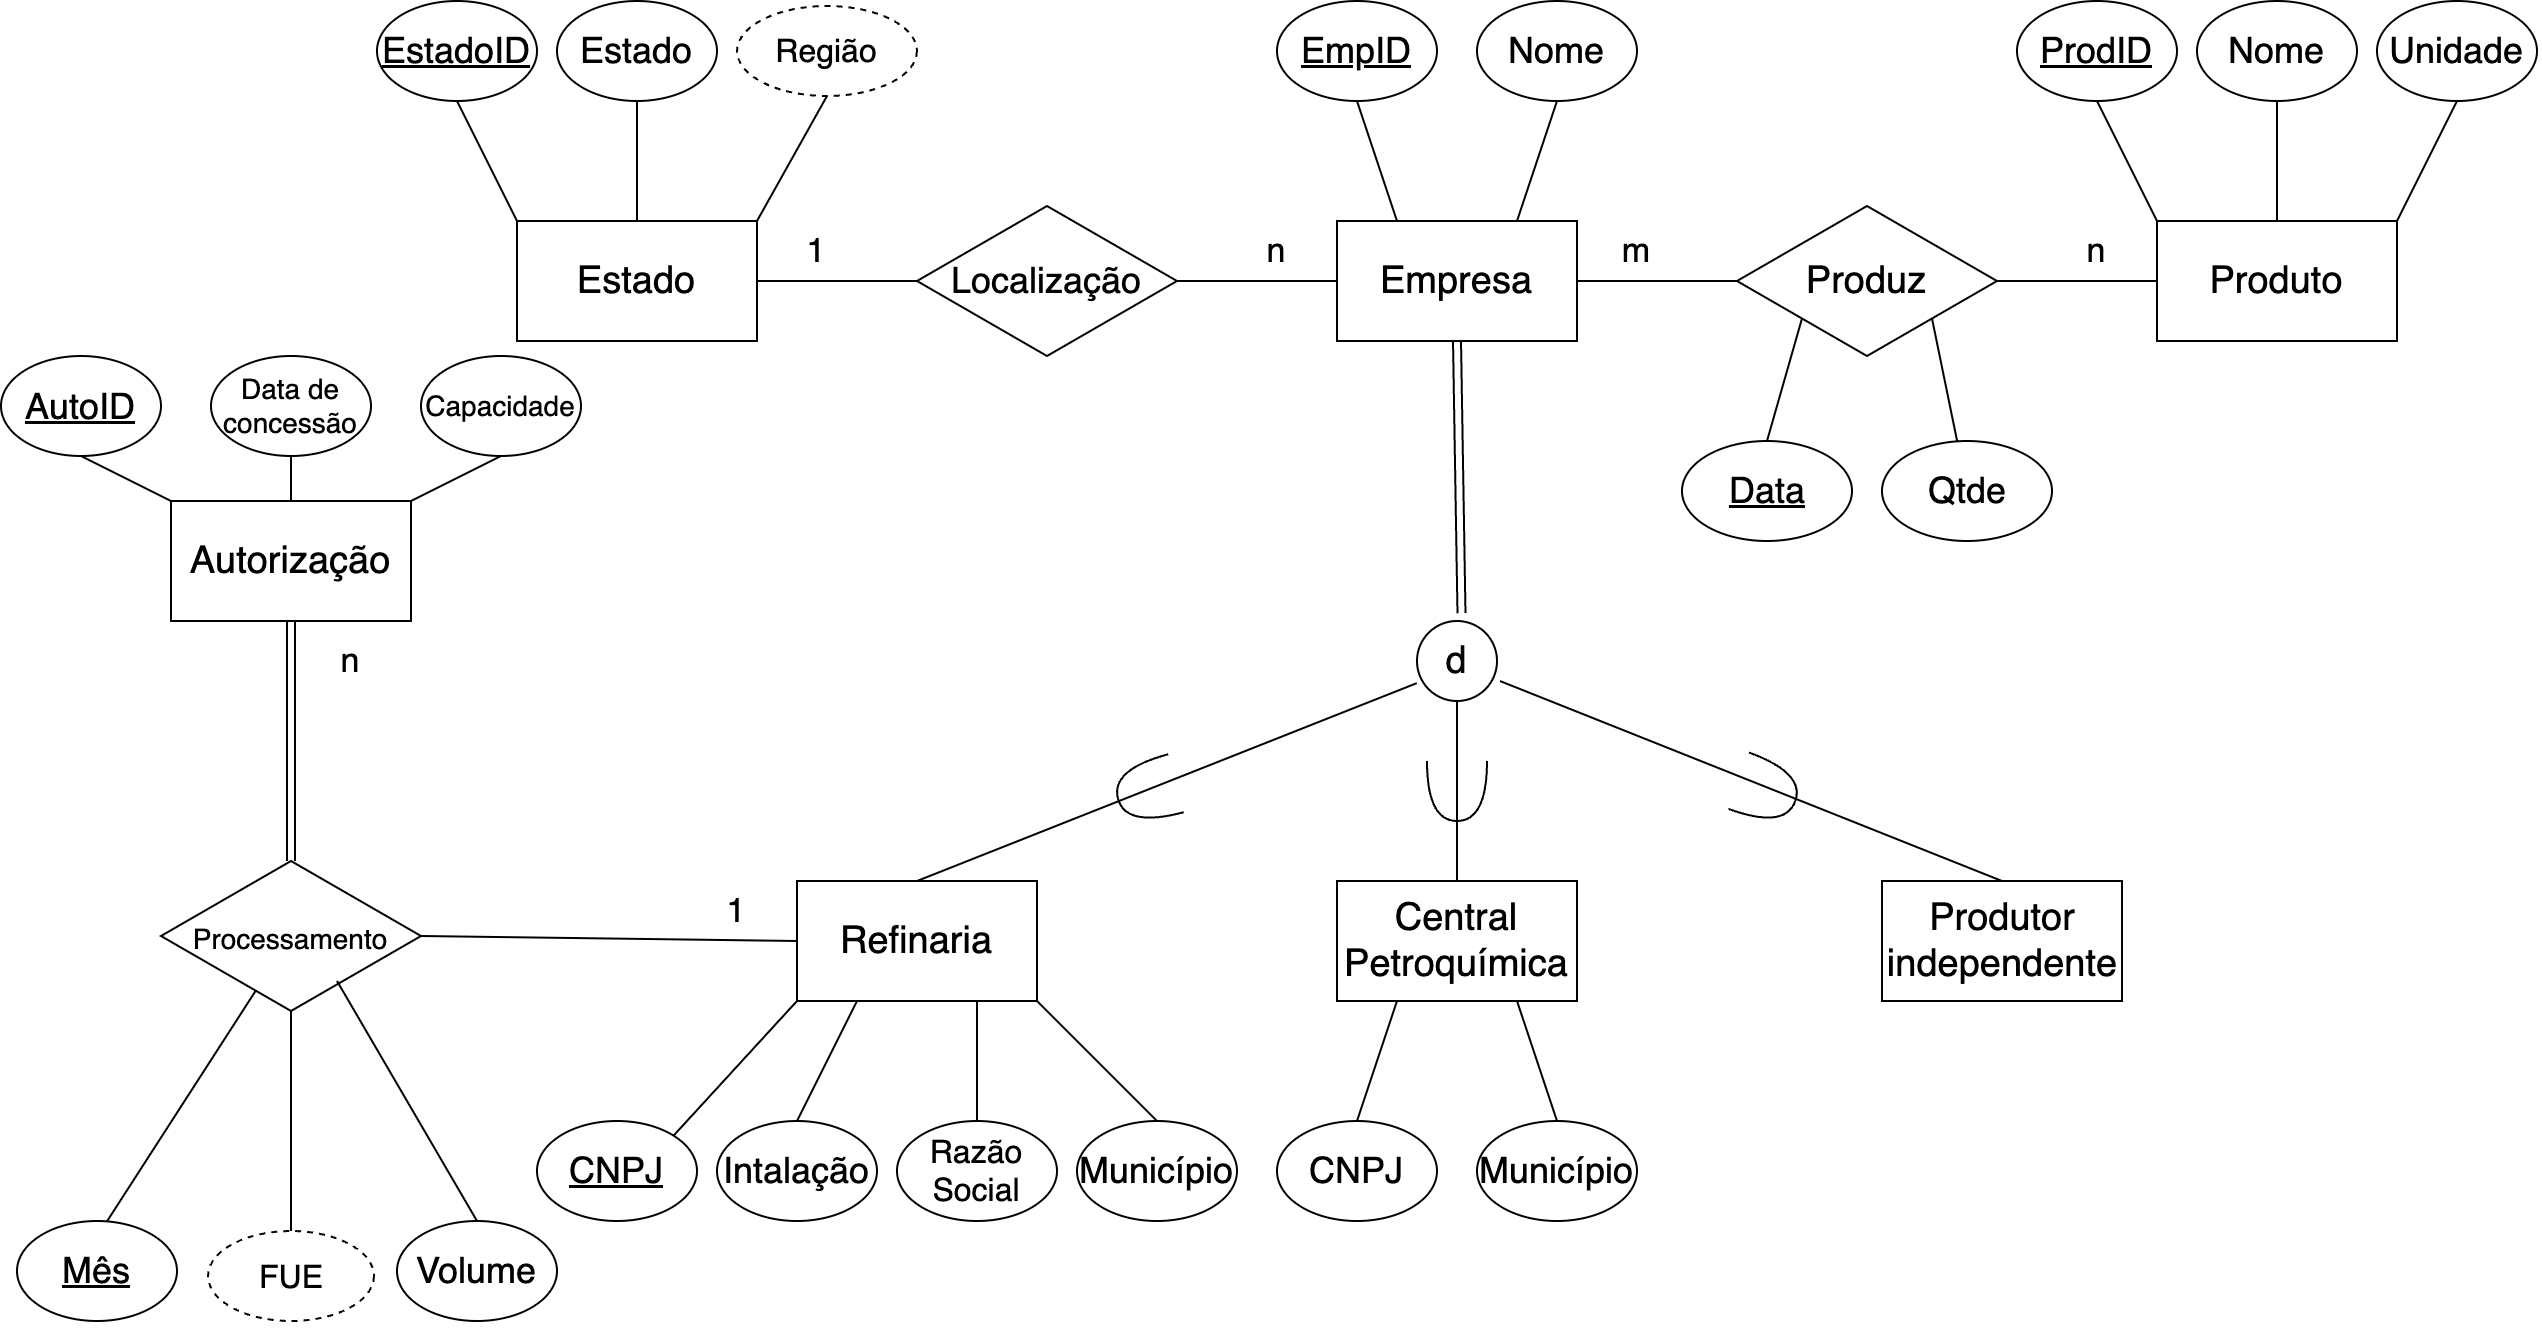

# 5. Diagrama relacional

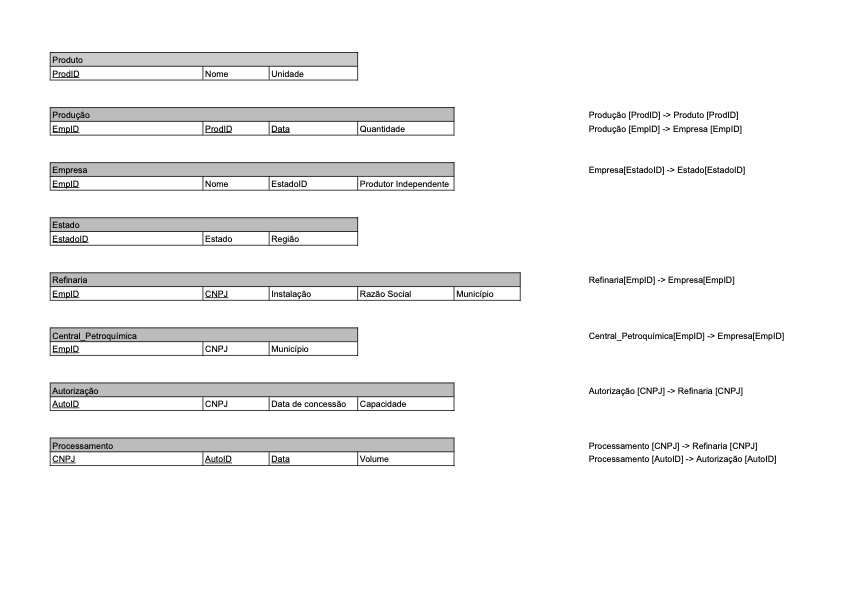

# 6. Consultas

In [42]:
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1

### Refinarias que são instalações da Petrobrás

In [43]:
query = '''
SELECT
    Instalacao, CNPJ
FROM Refinaria
WHERE RazaoSocial = 'PETROLEO BRASILEIRO S/A'
'''

df = pd.read_sql_query(query, conn)
df


,Instalacao,CNPJ
0,LUBNOR,33000167005502
1,REDUC,33000167008862
2,REGAP,33000167009320
3,REFAP,33000167010255
4,RLAM,33000167014323
5,RPBC,33000167014757
6,UN-SIX,33000167049623
7,REPLAN,33000167064347
8,REMAN,33000167079379
9,REPAR,33000167080970


### 6.1.2 Consulta 2

### Verificação dos meses em 2023 nos quais empresas deixaram de realizar processamento mesmo possuindo autorização

In [44]:
query = '''
SELECT CNPJ, Data
FROM Processamento
WHERE Volume = 0 and strftime('%Y', Data) >= '2023';
'''

df = pd.read_sql_query(query, conn)
df


,CNPJ,Data
0,4585532000199,2023-08-01
1,33412081000196,2023-03-01
2,40180943000168,2023-07-01
3,40180943000168,2023-08-01
4,30459634000178,2023-01-01
5,30459634000178,2023-02-01
6,30459634000178,2023-03-01
7,30459634000178,2023-04-01
8,30459634000178,2023-05-01
9,30459634000178,2023-06-01


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3

### Taxa de variação de uma capacidade autorizada em relação a alguma anterior

In [45]:
query = '''
SELECT
    A1.CNPJ,
    A2.DataConcessaoAnterior,
    A1.DataConcessao AS DataConcessaoAtual,
    A2.CapacidadeAnterior,
    A1.Capacidade AS CapacidadeAtual,
    ((A1.Capacidade - A2.CapacidadeAnterior) * 100 / A2.CapacidadeAnterior) AS CrescimentoPercentual
FROM Autorizacao A1
INNER JOIN (
    SELECT
        AutoID AS A2_AutoID,
        CNPJ AS A2_CNPJ,
        DataConcessao AS DataConcessaoAnterior,
        Capacidade AS CapacidadeAnterior
    FROM Autorizacao
) A2 ON A1.CNPJ = A2.A2_CNPJ AND A1.DataConcessao > A2.DataConcessaoAnterior
ORDER BY A1.CNPJ, A2.DataConcessaoAnterior DESC;
'''

df = pd.read_sql_query(query, conn)
df


,CNPJ,DataConcessaoAnterior,DataConcessaoAtual,CapacidadeAnterior,CapacidadeAtual,CrescimentoPercentual
0,33000167014757,2019-01-01 00:00:00,2019-11-01 00:00:00,27000,28488,5
1,33412081000196,2019-04-01 00:00:00,2021-12-01 00:00:00,1590,2274,43
2,33412081000196,2019-01-01 00:00:00,2019-04-01 00:00:00,2226,1590,-28
3,33412081000196,2019-01-01 00:00:00,2021-12-01 00:00:00,2226,2274,2
4,4585532000199,2019-01-01 00:00:00,2022-02-01 00:00:00,333,637,91


### 6.2.2 Consulta 4

### Empresas por estado, ordenadas pelo número de empresas

In [46]:
query = '''
    SELECT E.Estado, COUNT(EmpID) AS "Numero de Empresas"
    FROM Estado E NATURAL JOIN Empresa
    GROUP BY E.Estado
    ORDER BY "Numero de Empresas" DESC;
 '''

df = pd.read_sql_query(query, conn)
df

,Estado,Numero de Empresas
0,São Paulo,6
1,Paraná,4
2,Bahia,4
3,Rio Grande do Sul,3
4,Rio de Janeiro,2
5,Rio Grande do Norte,2
6,Amazonas,2
7,Pernambuco,1
8,Minas Gerais,1
9,Ceará,1


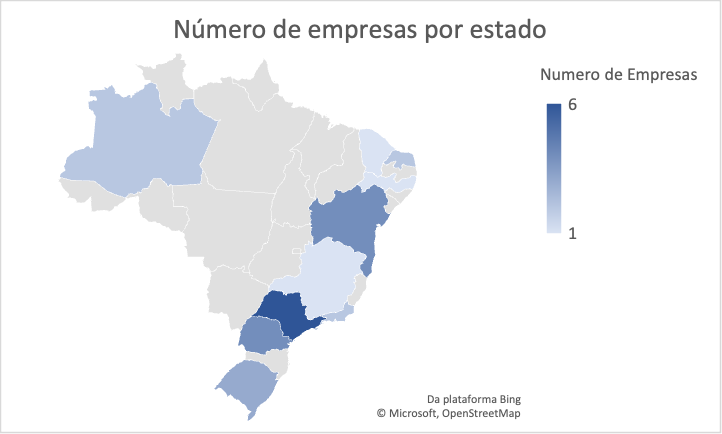

### 6.2.3 Consulta 5

### Identificar os meses de 2023 em que refinarias processaram um volume maior do que a própria média anual (referente ao mesmo ano)

In [47]:
query = '''
SELECT Instalacao, Data, Volume
FROM Refinaria NATURAL JOIN (SELECT CNPJ, Data, Volume
								             FROM Processamento AS P1
								             WHERE strftime('%Y', P1.Data) >= '2023' AND P1.Volume > (SELECT AVG(P2.Volume)
                                                         								              FROM Processamento AS P2
                                                         								              WHERE strftime('%Y', P2.Data) >= '2023'
                                                         								              GROUP BY P2.CNPJ
                                                        								              HAVING P1.CNPJ =  P2.CNPJ));
'''

df = pd.read_sql_query(query, conn)
df

,Instalacao,Data,Volume
0,DAX OIL,2023-01-01,402
1,DAX OIL,2023-02-01,434
2,DAX OIL,2023-03-01,460
3,DAX OIL,2023-04-01,468
4,DAX OIL,2023-05-01,413
...,...,...,...
72,REFMAT,2023-02-01,49645
73,3R POTIGUAR S.A.,2023-07-01,5428
74,RIOGRANDENSE,2023-01-01,2466
75,RIOGRANDENSE,2023-02-01,2447


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6

### Produção de GLP por estado de 2019 a 2023


In [48]:
query = '''
SELECT
    p.Nome AS Produto,
    p.Unidade AS Unidade,
    e.Estado,
    SUM(pr.Quantidade) AS ProducaoTotal
FROM Producao pr
JOIN Produto p ON pr.ProdID = p.ProdID
JOIN Empresa em ON pr.EmpID = em.EmpID
JOIN Estado e ON em.EstadoID = e.EstadoID
WHERE p.Nome = 'GLP ' AND strftime('%Y', pr.Data) BETWEEN '2019' AND '2023'
GROUP BY p.Nome, e.Estado, p.Unidade
ORDER BY ProducaoTotal DESC;
'''

df = pd.read_sql_query(query, conn)
df


,Produto,Unidade,Estado,ProducaoTotal
0,GLP,kg,São Paulo,8.178487e+09
1,GLP,kg,Rio de Janeiro,3.229970e+09
2,GLP,kg,Bahia,2.221755e+09
3,GLP,kg,Paraná,2.203389e+09
4,GLP,kg,Rio Grande do Sul,1.878568e+09
5,GLP,kg,Minas Gerais,1.574938e+09
6,GLP,kg,Pernambuco,2.198453e+08
7,GLP,kg,Rio Grande do Norte,1.810818e+08
8,GLP,kg,Amazonas,8.888792e+07
9,GLP,kg,Ceará,1.401452e+07


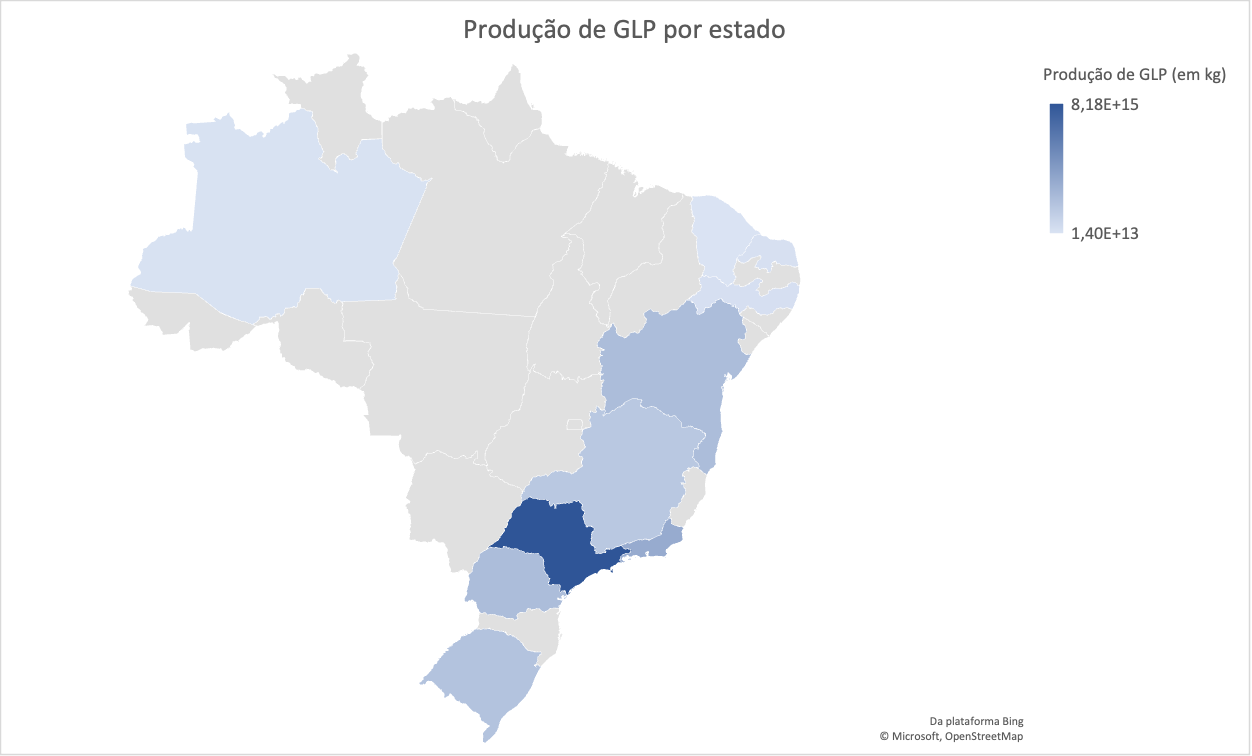

### 6.3.2 Consulta 7

### Comparar produção de gasolina A por cada macrorregião (Centro-Oeste, Nordeste, Norte, Sudeste e Sul)


In [49]:
query = '''
SELECT es.Regiao, SUM(pr.Quantidade) AS ProducaoTotalGasolinaA
FROM Producao pr
JOIN Produto p ON pr.ProdID = p.ProdID
JOIN Empresa em ON pr.EmpID = em.EmpID
JOIN Estado es ON em.EstadoID = es.EstadoID
WHERE p.Nome = 'Gasolina A '
GROUP BY es.Regiao;
'''

df = pd.read_sql_query(query, conn)
df

,Regiao,ProducaoTotalGasolinaA
0,NORDESTE,2.562821e+09
1,NORTE,3.199336e+06
2,SUDESTE,1.261664e+09
3,SUL,2.451047e+09


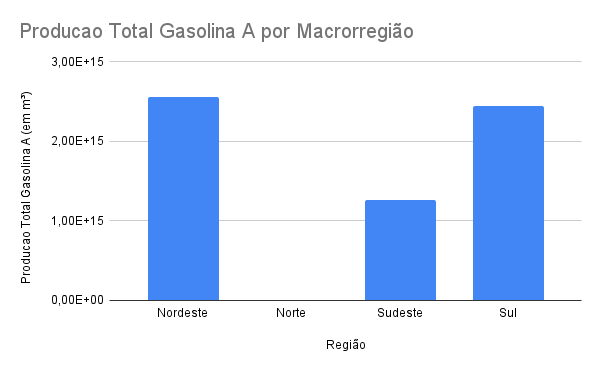

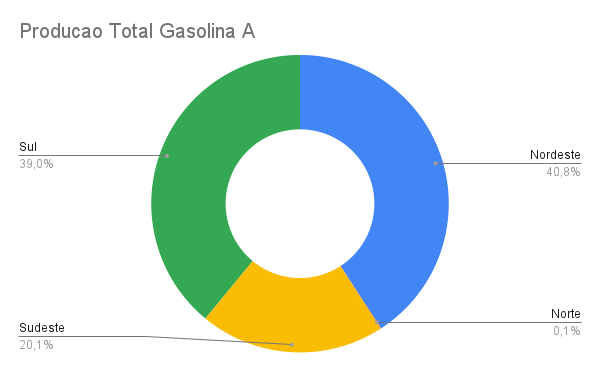

### 6.3.3 Consulta 8

### Produção total de cada produto, com a respectiva unidade de medida, por cada empresa

In [50]:
query = '''
SELECT
    em.Nome AS Empresa,
    p.Nome AS Produto,
    p.Unidade AS UnidadeDeMedida,
    SUM(pr.Quantidade) AS QuantidadeTotal
FROM Producao pr
JOIN Produto p ON pr.ProdID = p.ProdID
JOIN Empresa em ON pr.EmpID = em.EmpID
GROUP BY em.Nome, p.Nome, p.Unidade;
'''

df = pd.read_sql_query(query, conn)
df

,Empresa,Produto,UnidadeDeMedida,QuantidadeTotal
0,3R POTIGUAR S.A.,DMA-MGO,m³,13406.0
1,3R POTIGUAR S.A.,Nafta,m³,32601.0
2,3R POTIGUAR S.A.,Óleo Diesel S10,m³,0.0
3,3R POTIGUAR S.A.,Óleo Diesel S500,m³,27963.0
4,BRASKEM S/A,GLP,kg,457718143.0
...,...,...,...,...
230,SSOIL,Óleo Combustível,kg,27540.0
231,SSOIL,Óleo Diesel S500,m³,1611.0
232,UN-SIX,GLP,kg,15548334.0
233,UN-SIX,Nafta,m³,116703.0


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9

### Identificar a empresa que mais produziu, no ano de 2023, cada tipo de produto


In [51]:
query = '''
SELECT Nome AS NomeProduto, NomeEmpresa AS MaiorProdutor2023, Regiao
FROM (SELECT IDProd, EmpID, NomeEmpresa, MAX(QuantidadeProduzida2023), Regiao
			FROM (SELECT ProdID AS IDProd, EmpID, Nome AS NomeEmpresa, SUM(Quantidade) AS QuantidadeProduzida2023, Regiao
						FROM Producao NATURAL JOIN Empresa NATURAL JOIN Estado
						WHERE strftime('%Y', Data) >= '2023'
						GROUP BY ProdID, EmpID)
			GROUP BY IDProd
			ORDER BY IDProd) JOIN Produto ON IDProd = ProdID;
'''

df = pd.read_sql_query(query, conn)
df

,NomeProduto,MaiorProdutor2023,Regiao
0,Gasolina A,BRASKEM S/A,NORDESTE
1,Nafta,REDUC,SUDESTE
2,Solventes,RPBC,SUDESTE
3,Asfalto,REPAR,SUL
4,Cimento Asfáltico,REGAP,SUDESTE
5,DMA-MGO,REDUC,SUDESTE
6,GLP,REPLAN,SUDESTE
7,Lubrificantes,REDUC,SUDESTE
8,Óleo Combustível,REDUC,SUDESTE
9,Óleo Combustível Marítimo,REFMAT,NORDESTE


### 6.4.2 Consulta 10

### Ordenar as refinarias que mais produzem Gasolina A

In [52]:
query = '''
SELECT
    r.Instalacao AS Refinaria,
    SUM(pr.Quantidade) AS QuantidadeTotalGasolinaA
FROM Producao pr
JOIN Produto p ON pr.ProdID = p.ProdID
JOIN Refinaria r ON pr.EmpID = r.EmpID
WHERE p.Nome = 'Gasolina A '
GROUP BY r.Instalacao
ORDER BY QuantidadeTotalGasolinaA DESC;
'''

df = pd.read_sql_query(query, conn)
df

,Refinaria,QuantidadeTotalGasolinaA
0,REPLAN,23891062.0
1,REPAR,14193965.0
2,REVAP,13709266.0
3,RPBC,10831867.0
4,REGAP,10058192.0
5,REFAP,9494248.0
6,REDUC,9116139.0
7,RLAM,7020795.0
8,REFMAT,5202110.0
9,RECAP,4856320.0


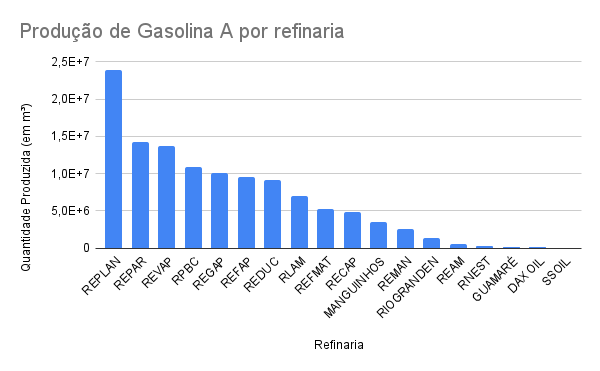

# 7. Autoavaliação dos membros

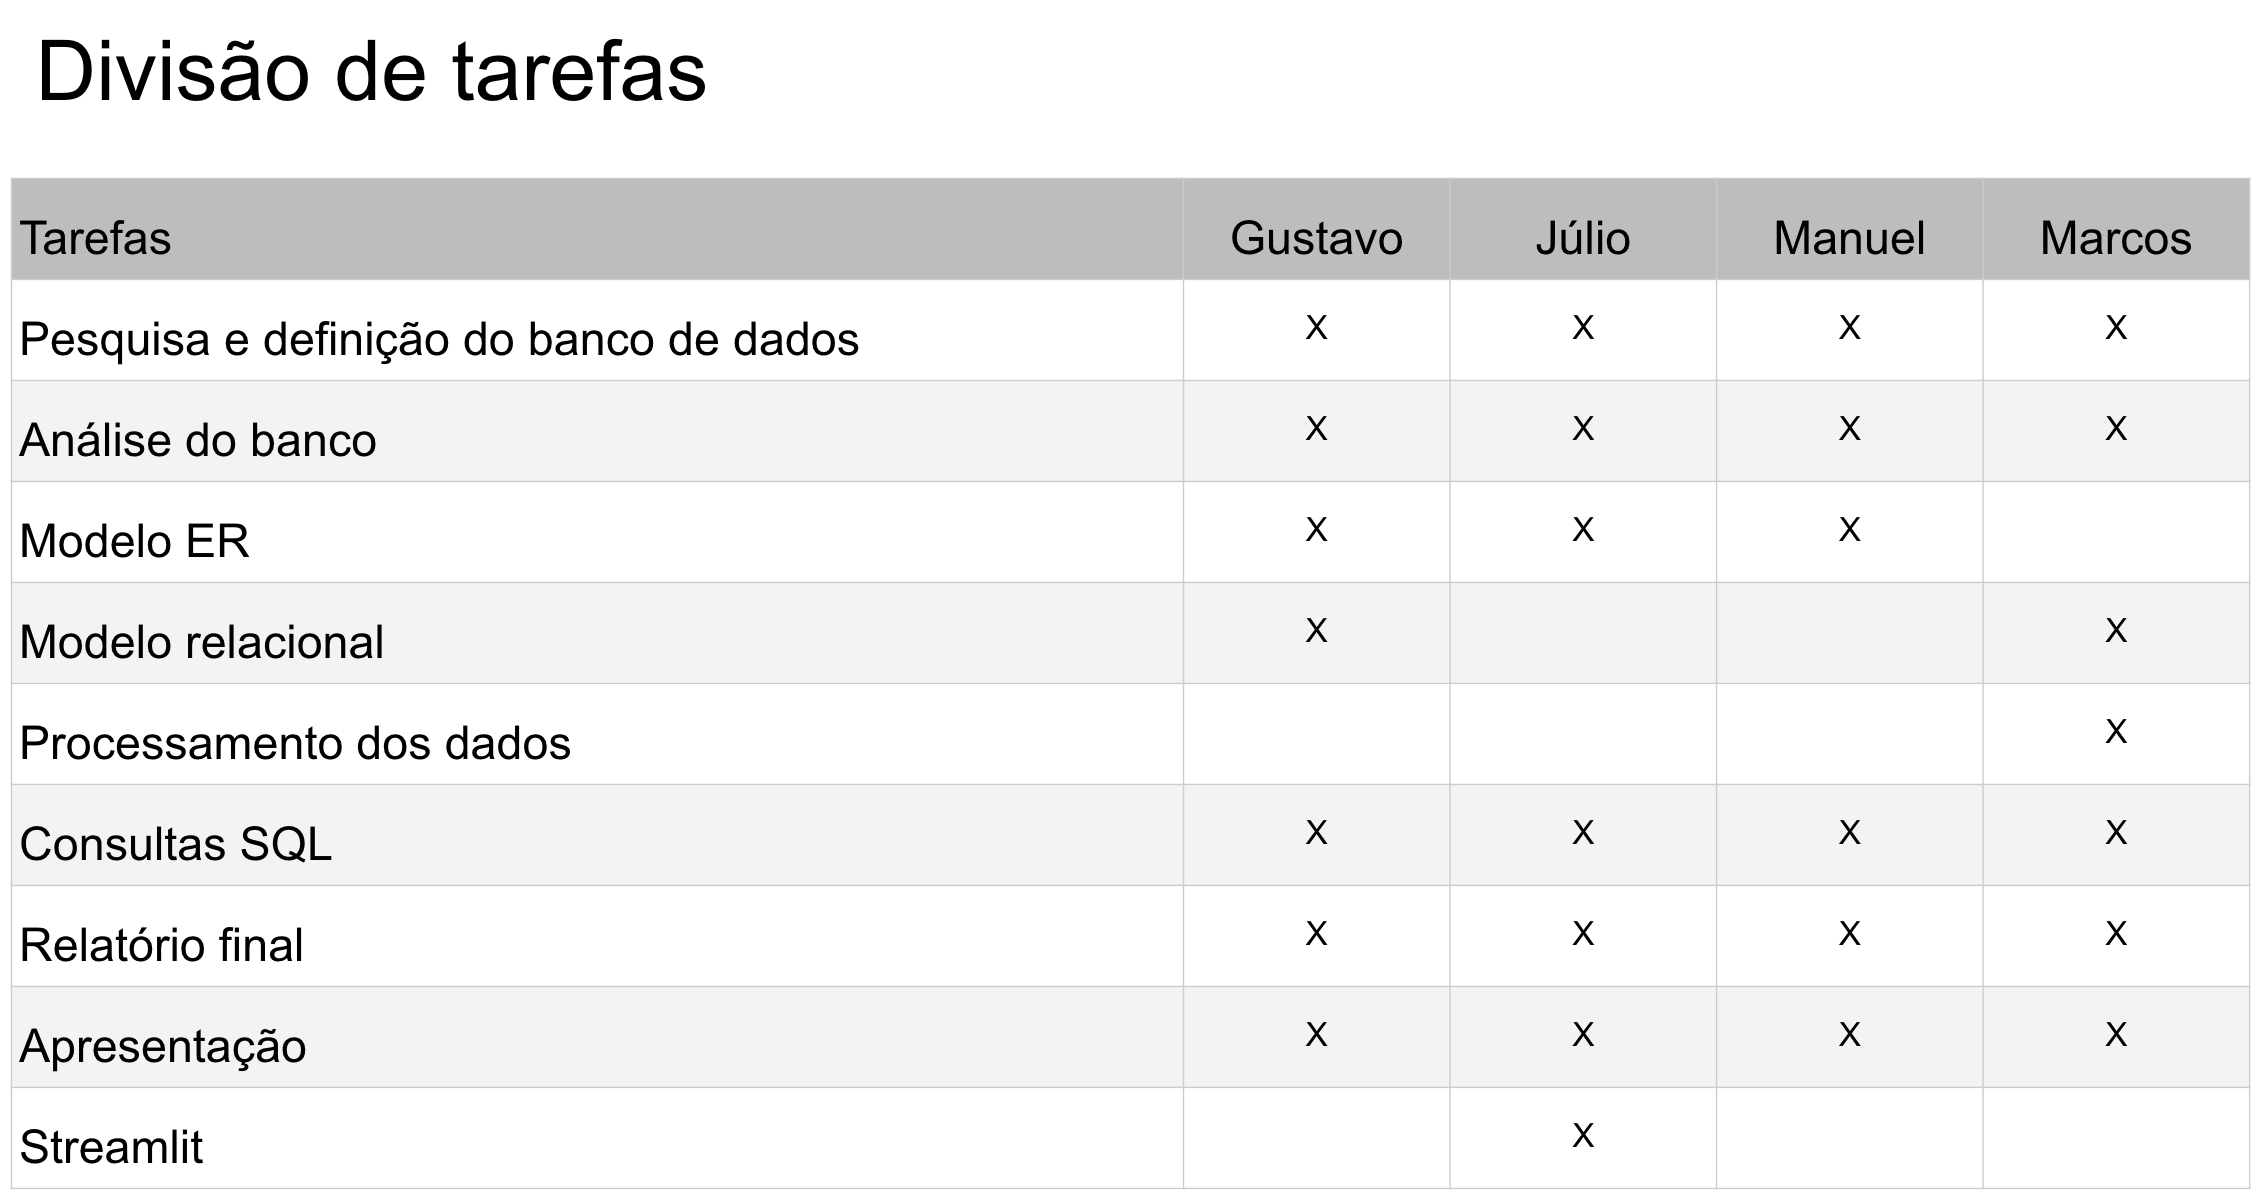

